In [1]:
# import libraries
import torch
import torch.distributions as D
import torch.nn.functional as F

from scipy.stats import norm, uniform
from scipy.stats import multivariate_normal as mvn

import matplotlib.pyplot as plt
import numpy as np

from nde.train import train
from nde.flows import construct_maf, count_parameters
from plot import PP_plot_1D, plot_2d_pdf_contours, PP_vals


### 3D gaussian distribution

Consider a 3D gaussian distribution: $f_X = \mathcal{N}(\mu,\Sigma)$ where $\mu = [\mu_1, \mu_2, \mu_3]$ and 
$\Sigma = \begin{pmatrix} \sigma_{1}^2 & \rho_{1,2} \sigma_1 \sigma_2 & \rho_{1,3} \sigma_1 \sigma_3\\ \rho_{1,2} \sigma_1 \sigma_2 & \sigma_{2}^2 & \rho_{2,3} \sigma_2 \sigma_3 \\ \rho_{1,3} \sigma_1 \sigma_3 & \rho_{2,3} \sigma_2 \sigma_3 & \sigma_{3}^2 \end{pmatrix}$.

We also define a *false* distribution (cf. earlier sections) where we rotate the covariance matrix around the 3rd dimension (z-axis) to investigate the impact on the one-dimensional pp-plots:

$$ \Sigma_{false} = R(\theta)\Sigma R(\theta)^T$$

with $R(\theta) = \begin{pmatrix} \cos(\theta) & -\sin(\theta) & 0 \\ \sin(\theta) & \cos(\theta) & 0 \\ 0 & 0 & 1 \end{pmatrix}$

In [2]:
# Parameters of the distribution
mu_1 = 0
mu_2 = 0
mu_3 = 0
sigma_1 = 1
sigma_2 = 1
sigma_3 = 1
rho_12 = 0.8
rho_13 = 0
rho_23 = 0
# rho_f_12 = -rho_12
# rho_f_13 = rho_13
# rho_f_23 = rho_23

def rotation_matrix(theta):
    return np.array([[np.cos(theta),-np.sin(theta),0],[np.sin(theta),np.cos(theta),0],[0,0,1]])

# True distribution: 3d gaussian
mean = np.array([mu_1, mu_2, mu_3])
covariance = np.array(
    [
        [sigma_1**2, rho_12 * sigma_1 * sigma_2, rho_13 * sigma_1 * sigma_3],
        [rho_12 * sigma_1 * sigma_2, sigma_2**2, rho_23 * sigma_2 * sigma_3],
        [rho_13 * sigma_1 * sigma_3, rho_23 * sigma_2 * sigma_3, sigma_2**3],
    ]
)
multi_normal_dist = mvn(mean=mean, cov=covariance)

# "False distribution": 2d gaussian with same mean and marginals but different correlation coefficient
mean_false = np.array([mu_1, mu_2, mu_3])
# covariance_false = np.array(
#     [
#         [sigma_1**2, rho_f_12 * sigma_1 * sigma_2, rho_f_13 * sigma_1 * sigma_3],
#         [rho_f_12 * sigma_1 * sigma_2, sigma_2**2, rho_f_23 * sigma_2 * sigma_3],
#         [rho_f_13 * sigma_1 * sigma_3, rho_f_23 * sigma_2 * sigma_3, sigma_2**3],
#     ]
# )
thetas = np.linspace(0,np.pi, 10)
covariance_false_list = [np.matmul(np.matmul(rotation_matrix(theta),covariance),rotation_matrix(theta).T) for theta in thetas]
false_mvns_list = [mvn(mean=mean_false, cov=cov_false) for cov_false in covariance_false_list]


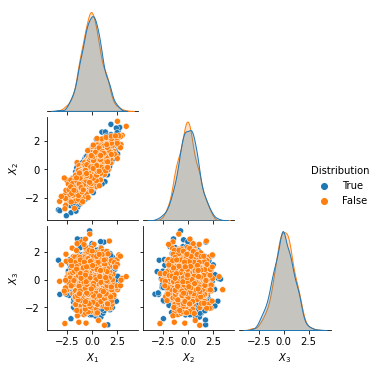

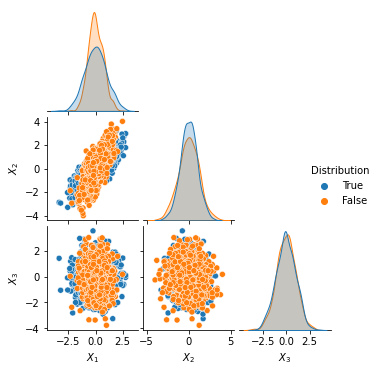

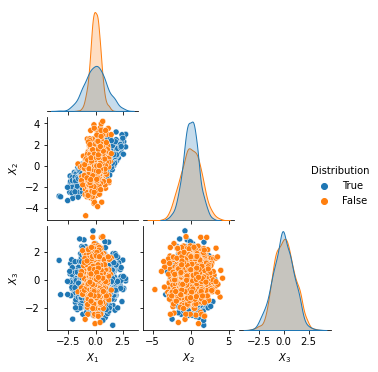

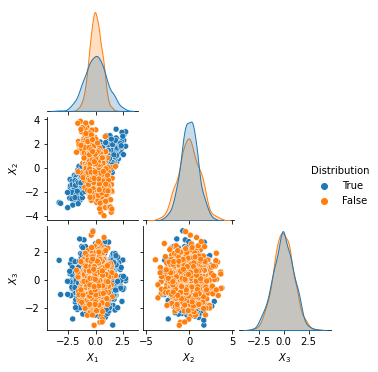

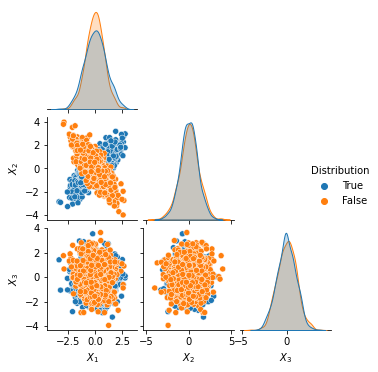

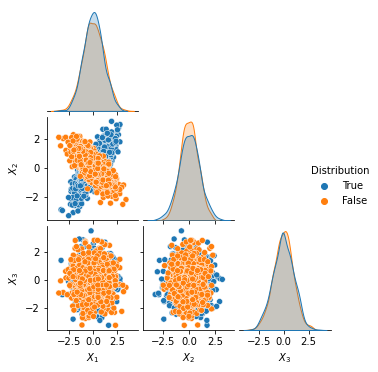

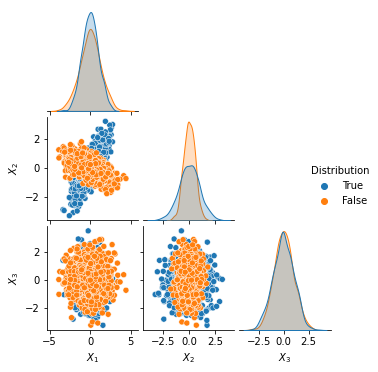

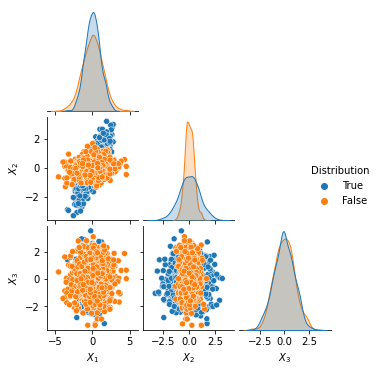

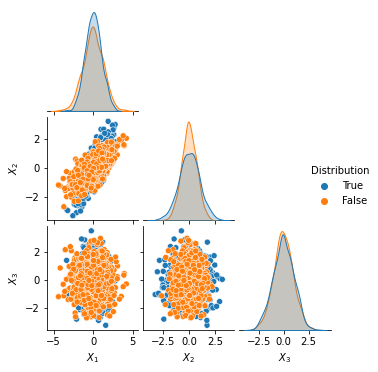

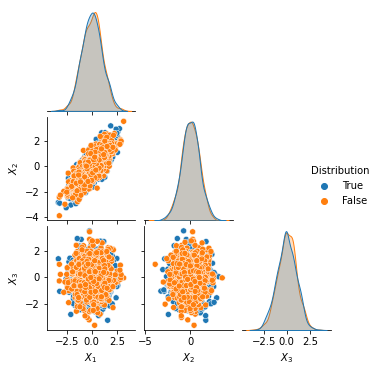

In [3]:
import pandas as pd
import seaborn as sns
# Plot distribution and PP-plots of the target distribution and the learned maf

# Pairplot
columns = [r"$X_1$", r"$X_2$", r"$X_3$"]
colors = ['blue', 'orange']

n = 1_000
samples_true = multi_normal_dist.rvs(n)
df_true = pd.DataFrame(samples_true, columns=columns)
df_true["Distribution"] = "True"

for i in range(len(thetas)):
    samples_false = false_mvns_list[i].rvs(n)
    df_maf = pd.DataFrame(samples_false, columns=columns)
    df_maf["Distribution"] = "False"

    dfs = pd.concat([df_true, df_maf], ignore_index=True)

    g = sns.pairplot(dfs, hue="Distribution", corner=True)
    # g.fig.suptitle("rotation angle = "+str(thetas[i]))
    g.fig.set_size_inches(5,5)
    plt.show()


In [4]:
# Define target distribution
means = torch.FloatTensor(mean)  # Defined in previous section
covs = torch.FloatTensor(covariance)  # Defined in previous section
target_dist = D.multivariate_normal.MultivariateNormal(means, covs)

# Get train and test samples:
# - train samples are used to train the flow,
# - cal samples are used to train the regressors 
# - test samples are used to plot the pp-plots (evaluate the regressors).
train_size = 10_000
cal_size = 5_000
test_size = 1_000

x_samples_train, x_samples_cal, x_samples_test = target_dist.sample((train_size,)), target_dist.sample((cal_size,)), target_dist.sample((test_size,))
print("NB training samples: ", x_samples_train.shape)
print("NB calibration samples: ", x_samples_cal.shape)
print("NB test samples: ", x_samples_test.shape)

NB training samples:  torch.Size([10000, 3])
NB calibration samples:  torch.Size([5000, 3])
NB test samples:  torch.Size([1000, 3])


In [5]:
# Define Flow: MAF (3 layer, 50 hidden features)
maf = construct_maf(
    x_samples_train,
    hidden_features=50,
    context_features=None,
    num_layers=4,
    random_permutation=False,
    standardize_transform=True,
)

In [6]:
# Train Flow
best_val_loss, epochs = train(
    maf,
    x_samples_train,
    num_epochs=2000,
    batch_size=10,
    lr=0.005,
    validation=True,
    plot=False,
    epochs_until_converge=20,
)

In [7]:
maf._transform._transforms[1]._transforms[0]

ReversePermutation()

In [8]:
x_new = x_samples_train[:1]
print(x_new)
for i in range(3):
    x_new = maf._transform._transforms[1]._transforms[i*2](x_new)[0]
    print(x_new)

tensor([[-1.8080, -0.6277,  0.6942]])
tensor([[ 0.6942, -0.6277, -1.8080]])
tensor([[-1.8080, -0.6277,  0.6942]])
tensor([[ 0.6942, -0.6277, -1.8080]])


## Eval on TRUE data distribution

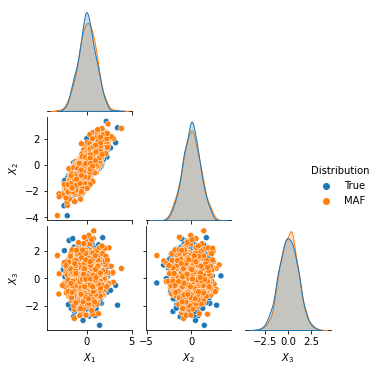

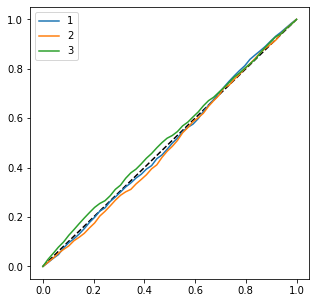

In [9]:
import pandas as pd
import seaborn as sns
# Plot distribution and PP-plots of the target distribution and the learned maf

# Pairplot
columns = [r"$X_1$", r"$X_2$", r"$X_3$"]
colors = ['blue', 'orange']

samples_true = np.array(x_samples_test)
df_true = pd.DataFrame(samples_true, columns=columns)
df_true["Distribution"] = "True"

maf_samples = maf.sample(test_size)
df_maf = pd.DataFrame(maf_samples.detach().numpy(), columns=columns)
df_maf["Distribution"] = "MAF"

dfs = pd.concat([df_true, df_maf], ignore_index=True)

g = sns.pairplot(dfs, hue="Distribution", corner=True)
g.fig.set_size_inches(5,5)
plt.show()

# MAF transformation
P_1_maf = norm.cdf(maf._transform(x_samples_test)[0][:, 0].detach().numpy())  # F_N(T^{-1}(x)_1)
P_2_maf = norm.cdf(maf._transform(x_samples_test)[0][:, 1].detach().numpy())  # F_N(T^{-1}(x)_2)
P_3_maf = norm.cdf(maf._transform(x_samples_test)[0][:, 2].detach().numpy())  # F_N(T^{-1}(x)_3)

plt.rcParams["figure.figsize"] = (5, 5)

# plot pp_plot variable 1
alphas = np.linspace(0, 1, 50)
# plot pp_plots variables 1,2,3
plt.plot(alphas,alphas, '--', color='black')
z_maf_1 = [np.mean(P_1_maf < alpha) for alpha in alphas]
plt.plot(alphas, z_maf_1, label='1')
z_maf_2 = [np.mean(P_2_maf < alpha) for alpha in alphas]
plt.plot(alphas, z_maf_2, label='2')
z_maf_3 = [np.mean(P_3_maf < alpha) for alpha in alphas]
plt.plot(alphas, z_maf_3, label='3')
plt.legend()
plt.show()



In [10]:
from sklearn.neural_network import MLPClassifier
import sklearn


DEFAULT_CLF = MLPClassifier(alpha=0, max_iter=25000)

# BASELINE
def multiPIT_regression_baseline(
    alphas, pit_values_train, classifier=DEFAULT_CLF,
):
    """ Estimate the 1D local PIT-distribution:
    
    Algorithm from [Zhao et. al, UAI 2021]: https://arxiv.org/abs/2102.10473
    --> adapted to multivariate data (conditionals).
    FOR EVERY ALPHA, the point-wise c.d.f 
        r_{\alpha} = P(PIT_i <= alpha | PIT_{1:i-1}) = E[1_{PIT_i <= alpha} | PIT_{1:i-1}]
    is learned as a function of X, by regressing 1_{PIT <= alpha} on X.

    inputs:
    - alphas: numpy array, size: (K,)
        Grid of alpha values. One alpha-value equals one regression problem.
    - pit_values_train: list of numpy arrays of size (N,) for each dim 
        pit values computed on N samples (\Theta, X) from the joint.
        Used to compute the regression targets W and the context data.
    - classifier: object
        Regression model trained to estimate the point-wise c.d.f. 
        Default is sklearn.MLPClassifier(alpha=0, max_iter=25000).
    
    output:
    - clfs: dict
        Trained regression models for each alpha-value.
    """
    clfs = {}
    for i,pit_i in enumerate(pit_values_train):
        pit_i = pit_i.ravel()
        clfs[i] = {}
        if i!=0:
            # context for conditional regression
            pit_context_train = np.concatenate(pit_values_train[:i], axis=1)
            for alpha in alphas:
                # compute the binary regression targets
                W_a_train = (pit_i <= alpha).astype(int)  # size: (N,)
                # define classifier
                clf = sklearn.base.clone(classifier)
                # train regression model
                clf.fit(X=pit_context_train, y=W_a_train)
                clfs[i][alpha] = clf
    return clfs

In [11]:
def infer_r_alphas_baseline(pit_eval, clfs):
    """ Infer the point-wise CDF for a given observation x_eval.

    inputs:
    - clfs: dict, keys: alpha-values
        Trained regression models for each alpha-value. 
        Ouput from the function "localPIT_regression_baseline". 

    output:
    - r_alphas: dict, keys: alpha-values 
        Estimated c.d.f values at x_eval: regressors evaluated in x_eval.
        There is one for every alpha value.
    """
    alphas = np.array(list(clfs.keys()))
    r_alphas = {}
    for alpha in alphas:
        # evaluate in x_eval
        prob = clfs[alpha].predict_proba(pit_eval)
        if prob.shape[1] < 2:  # Dummy Classifier
            r_alphas[alpha] = prob[:, 0][0]
        else:  # MLPClassifier or other
            r_alphas[alpha] = prob[:, 1][0]
    return r_alphas

In [12]:
P_1_maf_train = norm.cdf(maf._transform(x_samples_cal)[0][:, 0].detach().numpy())  # F_N(T^{-1}(x)_1)
P_2_maf_train = norm.cdf(maf._transform(x_samples_cal)[0][:, 1].detach().numpy())  # F_N(T^{-1}(x)_2)
P_3_maf_train = norm.cdf(maf._transform(x_samples_cal)[0][:, 2].detach().numpy())  # F_N(T^{-1}(x)_3)
pit_values_train = [P_1_maf_train.reshape(-1,1), P_2_maf_train.reshape(-1,1), P_3_maf_train.reshape(-1,1)]


In [13]:
clfs = multiPIT_regression_baseline(alphas = np.linspace(0,0.99,50),pit_values_train=pit_values_train)

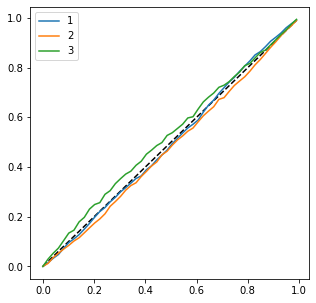

In [14]:
pit_values_eval = [P_1_maf.reshape(-1,1), P_2_maf.reshape(-1,1), P_3_maf.reshape(-1,1)]
alphas = np.linspace(0,0.99,50)
plt.plot(alphas,alphas, '--', color='black')
z_maf_1 = [np.mean(P_1_maf < alpha) for alpha in alphas]
plt.plot(alphas, z_maf_1, label='1')
r_alpha_2 = infer_r_alphas_baseline(np.concatenate(pit_values_eval[:1], axis=1),clfs[1])
pd.Series(r_alpha_2).plot(label='2')
r_alpha_3 = infer_r_alphas_baseline(np.concatenate(pit_values_eval[:2], axis=1),clfs[2])
pd.Series(r_alpha_3).plot(label='3')
plt.legend()

## Eval on FALSE data distribution

We keep the same trained MAF, but assume that the true data distribution is different than the samples the maf was trained on.

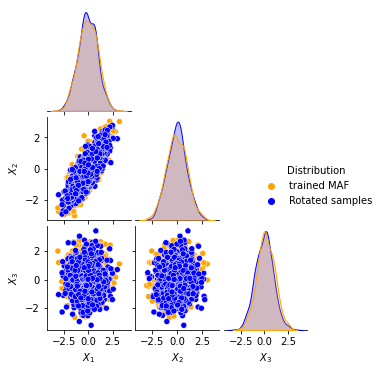

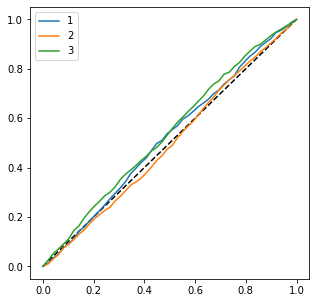

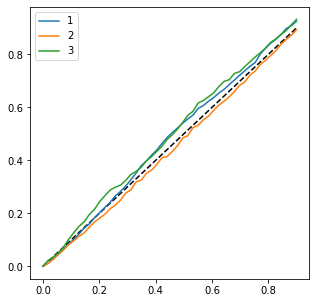

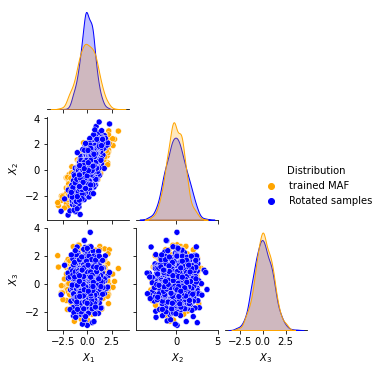

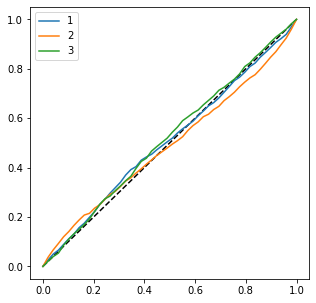

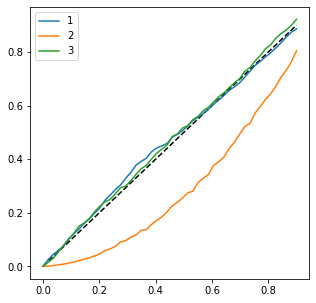

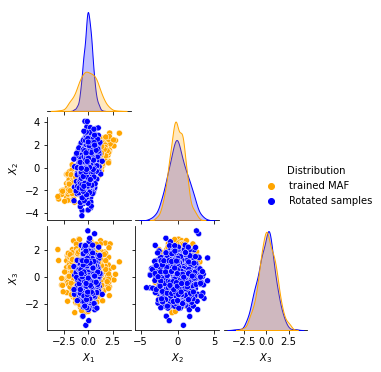

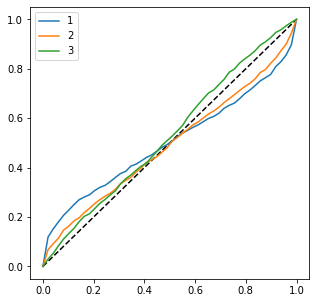

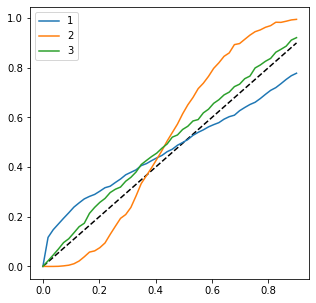

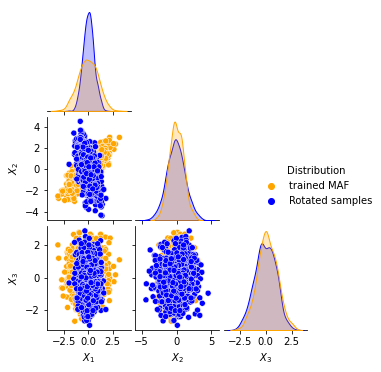

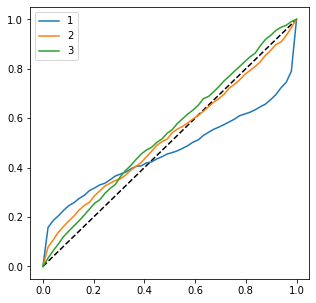

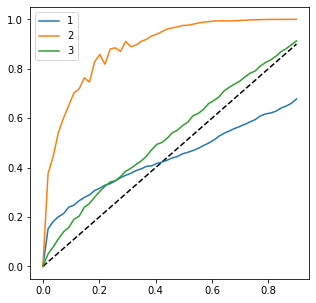

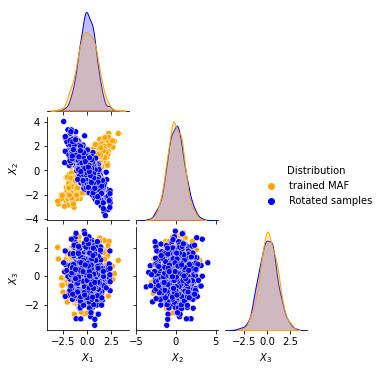

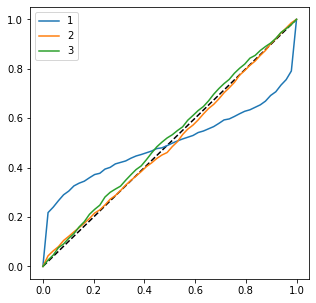

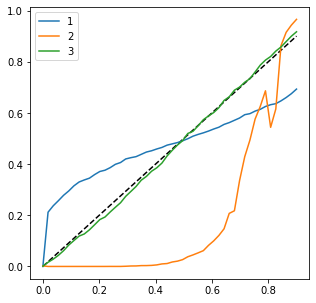

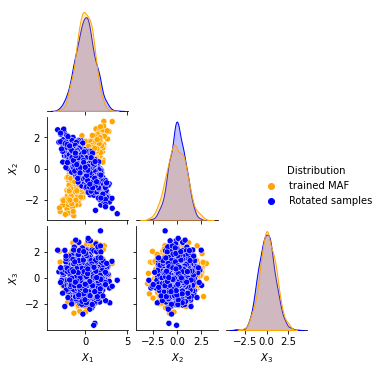

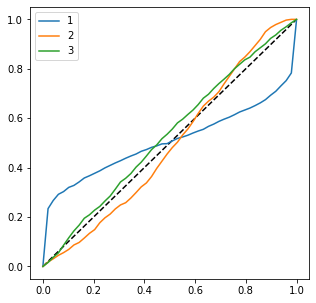

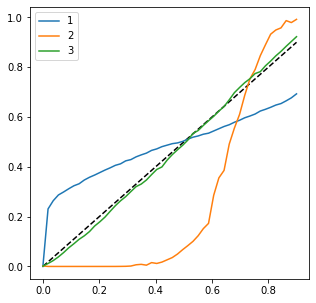

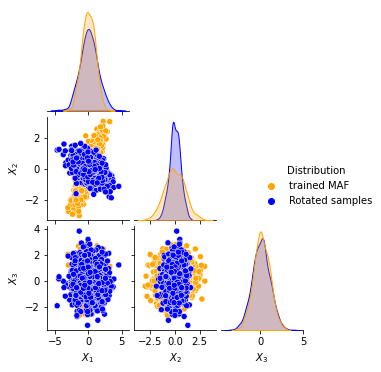

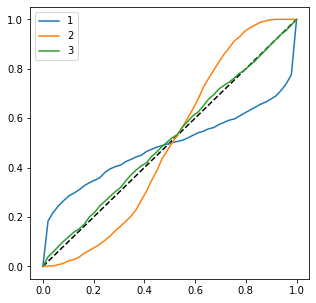

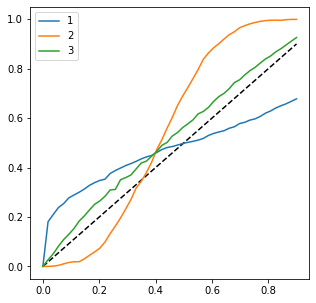

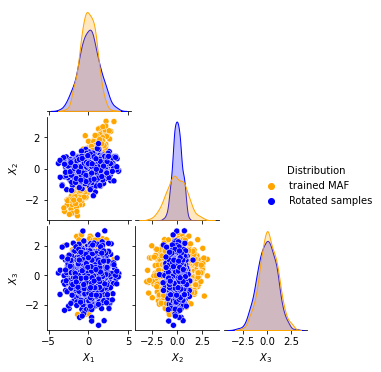

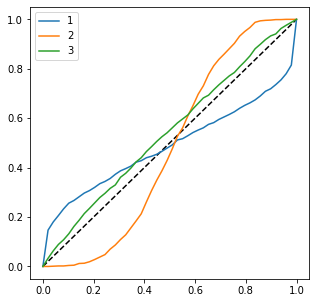

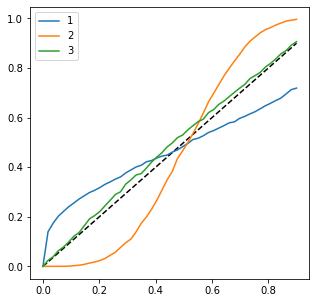

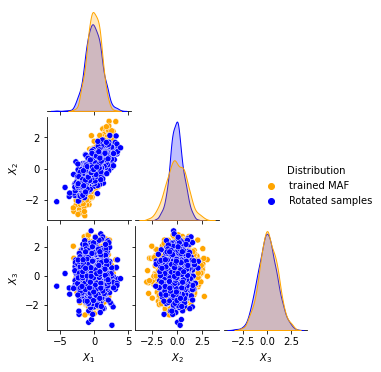

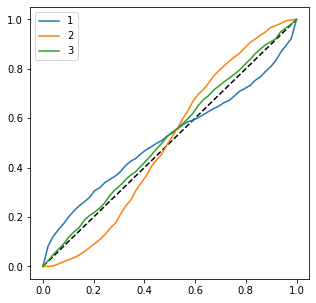

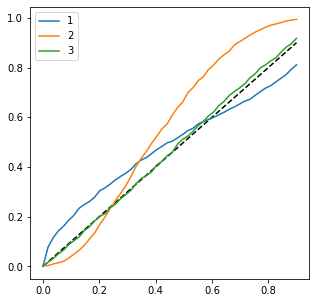

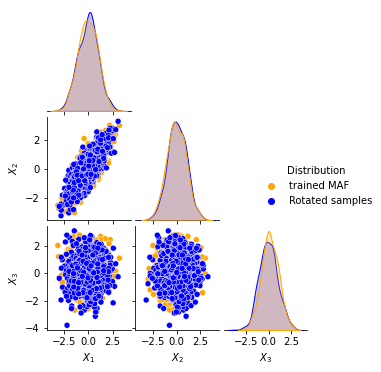

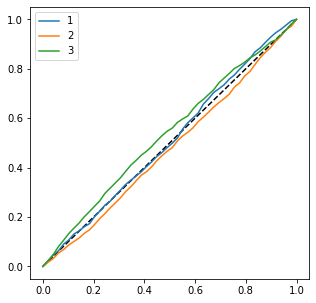

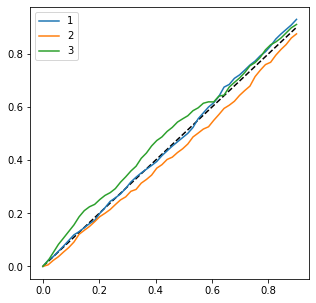

In [16]:
# Plot distribution and pp-plots of
# - the target distribution (here the false distribution) and
# - the learned maf (trained on the original data)

# Pairplot
columns = [r"$X_1$", r"$X_2$", r"$X_3$"]

maf_samples = maf.sample(n)
df_maf = pd.DataFrame(maf_samples.detach().numpy(), columns=columns)
df_maf["Distribution"] = "trained MAF"

for i in range(len(thetas)):
    samples_false_cal = false_mvns_list[i].rvs(cal_size)
    samples_false_test = false_mvns_list[i].rvs(test_size)

    df_false = pd.DataFrame(samples_false_test, columns=columns)
    df_false["Distribution"] = "Rotated samples"

    dfs = pd.concat([df_maf, df_false], ignore_index=True)

    g = sns.pairplot(dfs, hue="Distribution", corner=True, palette={"Rotated samples":"blue", "trained MAF": "orange"})
    # g.fig.suptitle("rotation angle = "+str(thetas[i]))
    g.fig.set_size_inches(5,5)
    plt.show()

    samples_false_test = torch.FloatTensor(samples_false_test)
    samples_false_cal = torch.FloatTensor(samples_false_cal)

    # MAF transformation on false samples
    P_1_maf = norm.cdf(maf._transform(samples_false_test)[0][:, 0].detach().numpy())  # 1D
    P_2_maf = norm.cdf(maf._transform(samples_false_test)[0][:, 1].detach().numpy())  # 1D
    P_3_maf = norm.cdf(maf._transform(samples_false_test)[0][:, 2].detach().numpy())  # 1D

    # plot pp_plots variables 1,2,3
    alphas = np.linspace(0,1,50)
    plt.plot(alphas,alphas, '--', color='black')
    z_maf_1 = [np.mean(P_1_maf < alpha) for alpha in alphas]
    plt.plot(alphas, z_maf_1, label='1')
    z_maf_2 = [np.mean(P_2_maf < alpha) for alpha in alphas]
    plt.plot(alphas, z_maf_2, label='2')
    z_maf_3 = [np.mean(P_3_maf < alpha) for alpha in alphas]
    plt.plot(alphas, z_maf_3, label='3')
    plt.legend()
    plt.title(r"p(P_i \leq alpha \mid P_{1:i-1})")

    plt.show()

    P_1_maf_train = norm.cdf(maf._transform(samples_false_cal)[0][:, 0].detach().numpy())  # 1D
    P_2_maf_train = norm.cdf(maf._transform(samples_false_cal)[0][:, 1].detach().numpy())  # 1D
    P_3_maf_train = norm.cdf(maf._transform(samples_false_cal)[0][:, 2].detach().numpy())  # 1D

    pit_values_train = [P_1_maf_train.reshape(-1,1), P_2_maf_train.reshape(-1,1), P_3_maf_train.reshape(-1,1)]
    alphas = np.linspace(0,0.9,50)
    clfs = multiPIT_regression_baseline(alphas = alphas, pit_values_train=pit_values_train)

    pit_values_eval = [P_1_maf.reshape(-1,1), P_2_maf.reshape(-1,1), P_3_maf.reshape(-1,1)]
    
    plt.plot(alphas,alphas, '--', color='black')
    z_maf_1 = [np.mean(P_1_maf < alpha) for alpha in alphas]
    plt.plot(alphas, z_maf_1, label='1')
    r_alpha_2 = infer_r_alphas_baseline(np.concatenate(pit_values_eval[:1], axis=1),clfs[1])
    pd.Series(r_alpha_2).plot(label='2')
    r_alpha_3 = infer_r_alphas_baseline(np.concatenate(pit_values_eval[:2], axis=1),clfs[2])
    pd.Series(r_alpha_3).plot(label='3')
    plt.legend()
    plt.title(r"p(P_i \leq alpha \mid P_{1:i-1})")
    plt.show()